# Heavy Traffic Indicators on I-94

## Interstate 94

Interstate 94 (I-94) is an east-west Interstate Highway connecting the Great Lakes and northern Great Plains regions of the United States. It lies along the primary overland route from Seattle to Toronto and is the only east-west Interstate highway to have a direct connection to Canada.

![](https://upload.wikimedia.org/wikipedia/commons/9/9d/Interstate_94_map.png)

*Interstate 94 in red, Image Source: [Wikimedia](https://commons.wikimedia.org/wiki/File:Interstate_94_map.png)*

## Project and Data Overview

Our goal is to analyze the traffic data made available by *John Hogue*, then determine a few indicators of heavy traffic on I-94. We will explore the data, examine relationships and create some visualizations. You can download the dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume#).

The dataset documentation mentions that a station located approximately midway between Minneapolis and Saint Paul recorded the traffic data. The station only records cars moving from east to west. Hence our results are limited to the westbound traffic in the proximity of that station. They are not applicable to the entire I-94 highway.

Here is a description of the columns in the dataset:

- `holiday`:- US National holidays plus regional holidays 
- `temp`:- Average temperature in kelvin 
- `rain_1h`:- Amount in millimetres of rain that occurred in the hour 
- `snow_1h`:- Amount in millimetres of snow that occurred in the hour 
- `clouds_all`:- Percentage of cloud cover 
- `weather_main`:- Short textual description of the current weather 
- `weather_description`:- Longer textual description of the current weather 
- `date_time`:- Time of data collection in local CST time 
- `traffic_volume`:- Hourly I-94 ATR 301 reported westbound traffic volume

## Importing Libraries

In [1]:
# Ignore future warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# Useful libraries
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
metro = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
metro.head(3)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767


In [3]:
metro.tail(3)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [4]:
metro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


### Initial Notes
- *The traffic dataset contains **48204 rows** and **9 columns**. No columns have null values.*
- *The dataset contains traffic data from 2012-10-02 09:00:00 to 2018-09-30 23:00:00.*
- *Numeric columns such as `temp`, `rain_1h`, `snow_h` and `clouds_all` do not have specified units of measurement. However, we have this information in our dataset description.*
- *The `date_time` column is stored as a string/object type rather than the DateTime type. Other colunms are assigned the correct datatypes*.
- *All columns follow the Python snake case naming convention*.

Before we begin our analysis, Let's convert the `date_time` column into a Pandas DateTime object:

In [5]:
metro['date_time'] = pd.to_datetime(metro['date_time'])
metro.dtypes

holiday                        object
temp                          float64
rain_1h                       float64
snow_1h                       float64
clouds_all                      int64
weather_main                   object
weather_description            object
date_time              datetime64[ns]
traffic_volume                  int64
dtype: object

## Analyzing Traffic Volume

+-------------+----------+
| statistic   |   values |
|-------------+----------|
| count       |    48204 |
| mean        |  3259.82 |
| std         |  1986.86 |
| min         |        0 |
| 25%         |     1193 |
| 50%         |     3380 |
| 75%         |     4933 |
| max         |     7280 |
+-------------+----------+


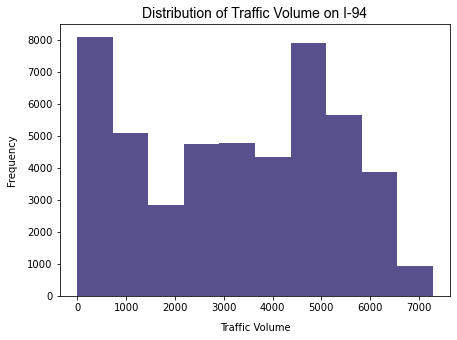

In [6]:
#plt.rcParams['figure.dpi'] = 100
table = (metro['traffic_volume'].describe()).to_frame()
print(tabulate(table, headers=['statistic', 'values'], tablefmt='psql', numalign="right"))

metro['traffic_volume'].plot.hist(color='#58508d', figsize=(7,5))
plt.title('Distribution of Traffic Volume on I-94', fontsize=14, fontname='Arial')
plt.xlabel('Traffic Volume', labelpad=10)
plt.ylabel('Frequency', labelpad=10)

plt.show()

### Observations
- *Traffic volume around the station does not present with a skewed, uniform nor normal distribution.*
- *Hourly traffic volume varied between 0 to 7,280 cars per hour, averaging around 3,260 cars. The mean and median values of the traffic distribution are also close to one another (mean: 3259, median: 3380)*
- *Traffic volumes between 0-1,500 and 4,500-5,500 are the most frequent, while volumes greater than 6,500 are less common.*
- *About 25% of the time, traffic volume was under 1,193 cars per hour. At the higher end of the spectrum, over 4933 cars pass through the station 25% of the time. This can also be confirmed by the two peaks from our chart.*

The last observation gives us an interesting question to explore. Could there be a time variable explanation? Considering that there could be less action at nighttime when people are at sleep than at day when people are usually off to work or returning. We will explore this possibility by comparing nightime to daytime data.

## Traffic Volumes: Day vs Night

We'll start by dividing the dataset into two parts:
- `Daytime data`: hours from 7 a.m. to 7 p.m (non-inclusive)
- `Nighttime data`: hours from 7 p.m. to 7 a.m (non-inclusive)

This may not be the perfect criteria for distinguishing nighttime from daytime, but it's a good starting point:

In [7]:
day = metro[(metro['date_time'].dt.hour >=7) & (metro['date_time'].dt.hour <19)]
night = metro[(metro['date_time'].dt.hour <7) | (metro['date_time'].dt.hour >=19)]

print('The shape of the I-94 daytime data is: {}'.format(day.shape))
print('The shape of the I-94 nighttime data is: {}'.format(night.shape))

The shape of the I-94 daytime data is: (23877, 9)
The shape of the I-94 nighttime data is: (24327, 9)


Now that we have extracted our daytime and nighttime data, let's attempt to visualize their respective traffic distributions:

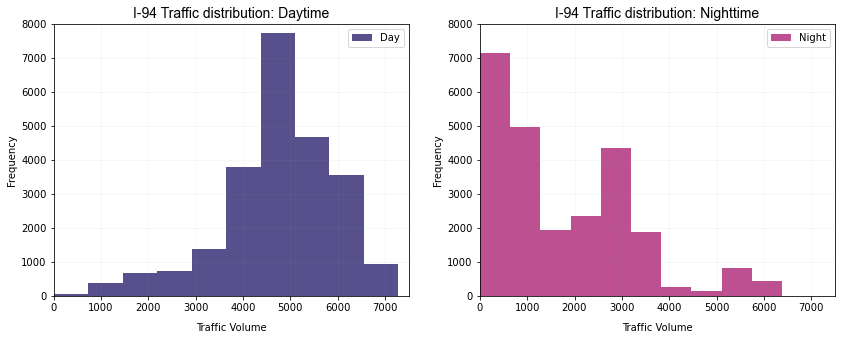

In [8]:
# Visualization
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
day['traffic_volume'].plot.hist(color='#58508d', label='Day')
plt.title('I-94 Traffic distribution: Daytime', fontsize=14, fontname='Arial')
plt.xlabel('Traffic Volume',labelpad=10)
plt.ylim([0,8000])
plt.xlim([0,7500])
plt.grid(True, color="#93a1a1", alpha=0.1)
plt.legend()

plt.subplot(1,2,2)
night['traffic_volume'].plot.hist(color='#bc5090', label='Night')
plt.title('I-94 Traffic distribution: Nighttime', fontsize=14, fontname='Arial')
plt.xlabel('Traffic Volume',labelpad=10)
plt.ylim([0,8000])
plt.xlim([0,7500])
plt.grid(True, color="#93a1a1", alpha=0.1)
plt.legend()

plt.show()

### Observations
**Daytime:**
- *Traffic distribution is left-skewed. This means that the incidence of fewer traffic are very rare, and higher traffic volumes are much more common. The bulk of traffic lies in the range of 4000 to 6500 vehicles per hour*.

**Nighttime**
- *Nighttime data shows a right skew, indicating an opposite pattern to daytime trends. At night, higher traffic volumes are less common. Infact, a considerable proportion of nighttime traffic was between 0 to 3000 vehicles per hour, much lesser than what was observed at daytime*

Let's further confirm these observations by computing descriptive statistics for both day and nighttime traffic:

In [9]:
df_1, df_2 = day[['traffic_volume']].describe(), night[['traffic_volume']].describe()

df_1.columns= ['daytime_traffic']
df_1['nighttime_traffic'] = df_2
df_1

,daytime_traffic,nighttime_traffic
count,23877.000000,24327.000000
mean,4762.047452,1785.377441
std,1174.546482,1441.951197
min,0.000000,0.000000
25%,4252.000000,530.000000
50%,4820.000000,1287.000000
75%,5559.000000,2819.000000
max,7280.000000,6386.000000


### Further Observations

The mean nighttime traffic of 1,785 as compared to 4,762 at daytime bolsters our claims. In addition:
- *75% of daytime traffic were in the range of 4,252 - 7,280 cars/hour. Conversely, nighttime recorded low traffic volumes in general (75% of the time, the traffic volumes recorded were lesser than 2,819 vehicles per hour).*

Considering that our goal to analyze the heavy traffic indicators, daytime data would be best suited for our analysis. We will focus on daytime traffic from now on.

## Time Indicators

One of the possible indicators of heavy traffic is time. There might be more people on the road in a certain month, on a certain day, or at a certain time of the day.

We're going to create a few line plots showing how the traffic volume changed according to the following parameters:
- Month
- Day of the week
- Time of day

### 1. Traffic Volume By Month

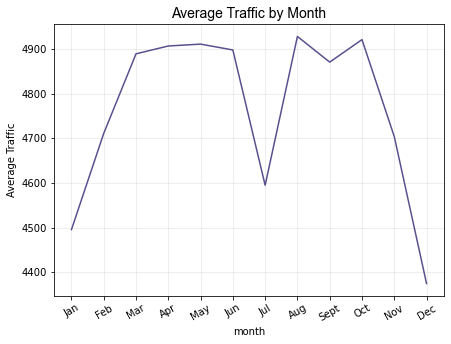

In [10]:
day['month'] = day['date_time'].dt.month

month_traffic = (day.groupby('month')['traffic_volume']
                     .mean()
                     .reset_index(name='avg_traffic')
                )

month_traffic.plot(x='month', y='avg_traffic', legend=None, color='#58508d', figsize=(7,5))
plt.ylabel('Average Traffic')
plt.title('Average Traffic by Month', fontsize=14, fontname='Arial')
plt.xticks(range(1,13), rotation=30,
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])
plt.grid(True, color="#93a1a1", alpha=0.2)

plt.show()

### Observations

- *Traffic volumes vary between 4000 and 5000 cars per hour every month. August and October are noticeably the months with the highest traffic activity. Traffic is also steadily high between March and June. On the other hand, January, February, November and December record lower traffic volumes.*
- *The traffic dip in July is unexpected. Our observations would have led us to assume that traffic volumes are generally higher at warmer periods than in the colder seasons (December, January and February). However, the notable decrease in July affects our ability to conclude.*

It would have been plausible to assume that the decreased traffic volume in July is attributed to the summer holidays around that period. However, June and August are also summer holiday months, and they do not seem to be affected by the trend. This suggests another probable cause. Let's explore our data for more insights. A good place to start is to check how traffic volumes evolved each year in July:

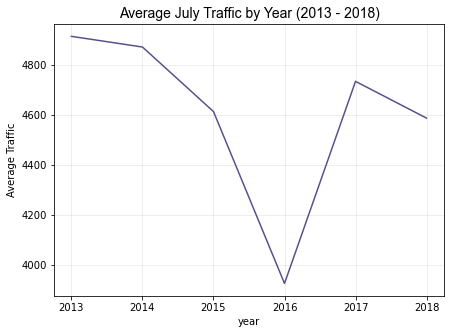

In [11]:
day['year'] = day['date_time'].dt.year
july_data = day[day['month'] == 7]

july_traffic = (july_data.groupby('year')
                    ['traffic_volume'].mean()
                    .reset_index(name='avg_traffic')
               )

july_traffic.plot(x='year', y='avg_traffic', figsize=(7,5), legend=None, color='#58508d')
plt.ylabel('Average Traffic')
plt.title('Average July Traffic by Year (2013 - 2018)', fontsize=14, fontname='Arial')
plt.grid(True, color="#93a1a1", alpha=0.2)
plt.show()

### Observation

- *On average, the traffic volume in July ranges from around 4,600 to 4800 cars per hour (similar to other summer months). However, there was a significant decrease in 2016. This occurrence might explain the low average we previously observed for July. Could a particular event have happened in 2016 to affect this traffic volume?*

Let's explore daytime traffic data over all the months in 2016: 

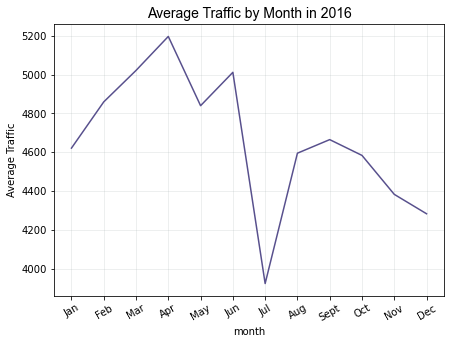

In [12]:
traffic_2016 = day[day['year'] == 2016]

month_2016 = (traffic_2016.groupby('month')['traffic_volume']
                     .mean()
                     .reset_index(name='avg_traffic')
                )

month_2016.plot(x='month', y='avg_traffic', legend=None, color='#58508d', figsize=(7,5))
plt.ylabel('Average Traffic')
plt.title('Average Traffic by Month in 2016', fontsize=14, fontname='Arial')
plt.xticks(range(1,13), rotation=30,
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])
plt.grid(True, color="#93a1a1", alpha=0.2)

plt.show()

July 2016 looks undoubtedly interesting. Something significant must have happened to cause this drop in traffic activity. Next, let's explore traffic activity over all the days in July 2016:

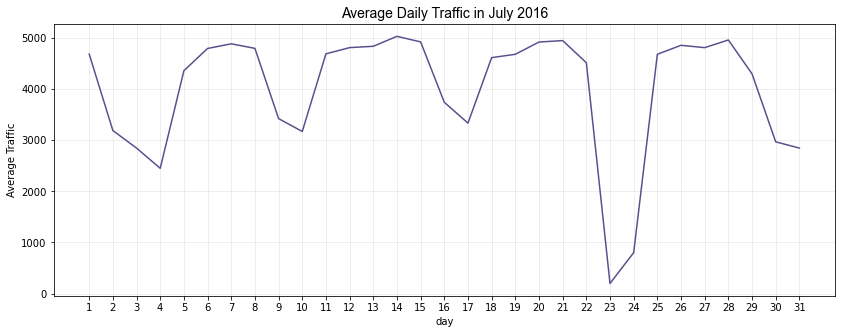

In [13]:
traffic_2016['day'] = traffic_2016['date_time'].dt.day
july_2016 = traffic_2016[traffic_2016['month'] == 7]

july_daily = (july_2016.groupby('day')
                    ['traffic_volume'].mean()
                    .reset_index(name='avg_traffic')
               )

july_daily.plot(x='day', y='avg_traffic', figsize=(14,5), legend=None, color='#58508d')
plt.ylabel('Average Traffic')
plt.title('Average Daily Traffic in July 2016', fontsize=14, fontname='Arial')
plt.xticks(range(1,32))
plt.grid(True, color="#93a1a1", alpha=0.2)
plt.show()

### Observation

- *Something unusual happened on the 23rd and 24th of July 2016 where traffic volumes plunged lesser than 1000 cars per hour. There could have been a road construction at the time, a conflict, or an accident, which could have reduced traffic activity on the road.*

A quick search of 23rd and 24th July 2016 with the keywords I-94 construction will yeild some favourable results. It appears that road construction activities took place on the interstate road around that period. You can find more information about this construction work at the [Department of transportation 2016 weekly updates](https://www.dot.state.mn.us/d4/projects/alexi94hwy29/weekly.html) and in [The crain's detroit business page](https://www.crainsdetroit.com/article/20160728/NEWS/160729841/weekend-construction-i-96-us-23-bridge-work-i-94-lane-closures-i-696).

### 2. Week Day and Traffic Volume

Earlier, we generated a line plot to explore how traffic volume changed each month on average. We'll now continue by building line plots for another time unit: day of the week.

To get the traffic volume averages for each day of the week, we will use the handy method `.dt.dayofweek()` to extract the day of the week from the `date_time` column. The resulting values will be a range of possible weekdays from monday (0) to Sunday (6):

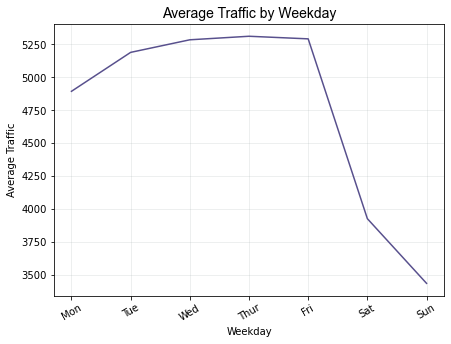

In [14]:
day['day_of_week'] = day['date_time'].dt.dayofweek

weekday_traffic = (day.groupby('day_of_week')['traffic_volume']
                     .mean()
                     .reset_index(name='avg_traffic')
                )

weekday_traffic.plot(x='day_of_week', y='avg_traffic', legend=None, color='#58508d', figsize=(7,5))
plt.xlabel('Weekday')
plt.ylabel('Average Traffic')
plt.title('Average Traffic by Weekday', fontsize=14, fontname='Arial')
plt.xticks(range(0,7), rotation=30,
           labels=['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
plt.grid(True, color="#93a1a1", alpha=0.2)

plt.show()

### Observation

- *Traffic is generally higher on working days (Mondays to Fridays), with average traffic of over 4500 cars per hour. On average, weekends (Saturday and Sunday) show lower traffic volumes (less than 4000 cars per hour).*

We can thus infer that we have more traffic on working days due to the cyclic activity of people going to and returning from work. To support our inference, we could check the exact periods of the day when higher traffic volumes are recorded. If our assumption is correct, we should observe particular spikes in traffic activity during rush hours when people go to work or return to their homes.

### 3. Traffic Volume and Time of Day

We will try to generate a line plot for the time of day. The weekends, however, will pull down the average values, since they generally record less traffic activity. To prevent this from happening, we will visualize the averages separately. 

We will start by splitting the data based on the day type: business day or weekend. To do this, we will use the `dataframe.query()` method. This returns a filtered dataframe based on the results of a boolean expression:

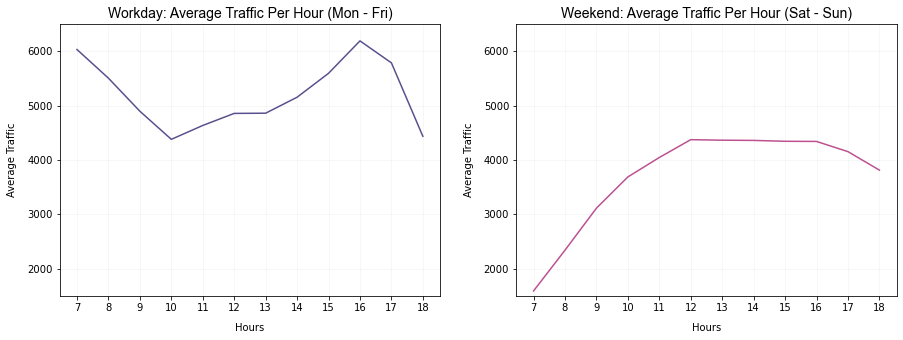

In [15]:
day['hour'] = day['date_time'].dt.hour

# Select data from Monday(0) to Friday(4)
workday = day.query("day_of_week <= 4")
# Select the weekends Saturday(5) and Sunday(6)
weekend = day.query("day_of_week > 4")

workday_traffic = (workday.groupby('hour')['traffic_volume']
                     .mean()
                     .reset_index(name='avg_traffic')
                  )

weekend_traffic = (weekend.groupby('hour')['traffic_volume']
                     .mean()
                     .reset_index(name='avg_traffic')
                  )

#Visualization
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(workday_traffic['hour'], workday_traffic['avg_traffic'], color='#58508d')
plt.title('Workday: Average Traffic Per Hour (Mon - Fri)', fontsize=14, fontname='Arial')
plt.xticks(range(7,19))
plt.ylim([1500, 6500])
plt.xlabel('Hours', labelpad=10)
plt.ylabel('Average Traffic', labelpad=10)
plt.grid(True, color="#93a1a1", alpha=0.1)

plt.subplot(1,2,2)
plt.plot(weekend_traffic['hour'], weekend_traffic['avg_traffic'], color='#bc5090')
plt.title('Weekend: Average Traffic Per Hour (Sat - Sun)', fontsize=14, fontname='Arial')
plt.xticks(range(7,19))
plt.ylim([1500, 6500])
plt.xlabel('Hours', labelpad=10)
plt.ylabel('Average Traffic', labelpad=10)
plt.grid(True, color="#93a1a1", alpha=0.1)

plt.show()

### Observation
- *Our weekday chart has two peaks corresponding to 7 am and 4 pm (both over 6000 cars/hr). This agrees with the expected rush hours (7 am when most people leave for work and 4 pm when people start to head home).*
- *The weekend shows a notably different pattern. Traffic volumes are lower compared to the workdays. Traffic builds up (around 4500 cars/hr) in the afternoon between 12 pm and 4 pm. This is understandable, considering that the period correspond to weekend leisure hours.*

### Notes From I-94 Time Data Analysis
- Warmer months are busier in traffic volume.
- A road construction activity took place on I-94 between 23rd and 24 July 2016. There was minimal traffic activity on those days.
- The road is busier on business days than weekends.
- On business days, 7 am and 4 pm are generally busier than other hours of the day.

## Weather Indicators

Another possible indicator of heavy traffic is weather. Our dataset provides us with a few useful columns about weather. Some of these columns are numerical while the others are categorical:

- **Numerical**: `temp`, `rain_1h`, `snow_1h` and `clouds_all`.
- **Categorical**: `weather_main`  and `weather_description`.


### 1. Numerical Weather Indicators
Let's start by looking at the correlation of numerical columns with `traffic_volume`:

In [16]:
day[['temp','rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']].corr()['traffic_volume']

temp              0.128317
rain_1h           0.003697
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
Name: traffic_volume, dtype: float64

From the output above, it appears that only temperature shows some correlation with traffic volume (approximately 0.13). This correlation is very minimal and we will attempt to demonstrate it using a scatterplot:

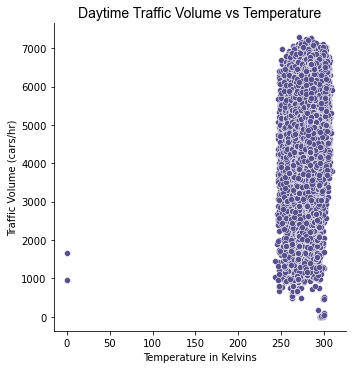

In [17]:
sns.relplot(data=day, x='temp', y='traffic_volume', color='#58508d')
plt.title('Daytime Traffic Volume vs Temperature', fontsize=14, fontname='Arial')
plt.ylabel('Traffic Volume (cars/hr)')
plt.xlabel('Temperature in Kelvins')
plt.show()

We have two points on the scatterplot with zero temperature. This is quite unusual. We will plot the graph again, ignoring the zero temperature. Let's set our x-axis limit to a range above zero kelvins.

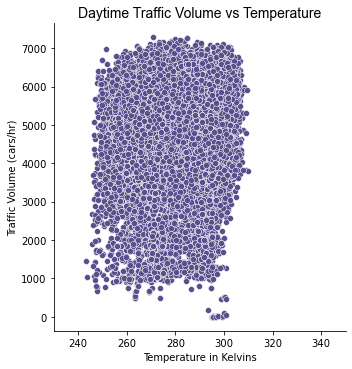

In [18]:
sns.relplot(data=day, x='temp', y='traffic_volume', color='#58508d')
plt.title('Daytime Traffic Volume vs Temperature', fontsize=14, fontname='Arial')
plt.xlim([230,350])
plt.ylabel('Traffic Volume (cars/hr)')
plt.xlabel('Temperature in Kelvins')
plt.show()

It appears that there isn't a strong correlation to conclude anything  useful about temperature and traffic volume. Let's turn our attention to the categorical columns: `weather_main` and `weather description`.

### 2. Categorical Weather Indicators

We will calculate the average traffic volume associated with each unique weather type and weather description, then visualize our findings.

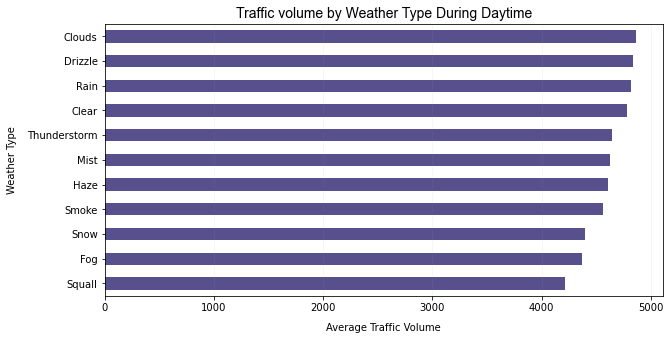

In [19]:
weather_type = (day.groupby('weather_main')['traffic_volume']
                     .mean()
                     .reset_index(name='avg_traffic')
                     .sort_values(by='avg_traffic')
                )


weather_type.plot.barh('weather_main', 'avg_traffic', legend=None, color='#58508d', figsize=(10,5))
plt.title('Traffic volume by Weather Type During Daytime', fontsize=14, fontname='Arial')
plt.xlabel('Average Traffic Volume', labelpad=10)
plt.ylabel('Weather Type', labelpad=10)
plt.grid(axis='x', color="#93a1a1", alpha=0.1)
plt.show()

### Observation

- *For time indicators, we considered heavy traffic when we observed averages of over 5,000 cars per hour. However, no weather category seems to cause traffic that exceeds the 5,000 mark. Although one could note that on cloudy, drizzly, rainy and clear days, traffic approaches 5,000 cars, there is not enough evidence to conclude the relationship between weather types and heavy traffic.*

Let's explore the more detailed weather description column to see if we can draw some additional insights:

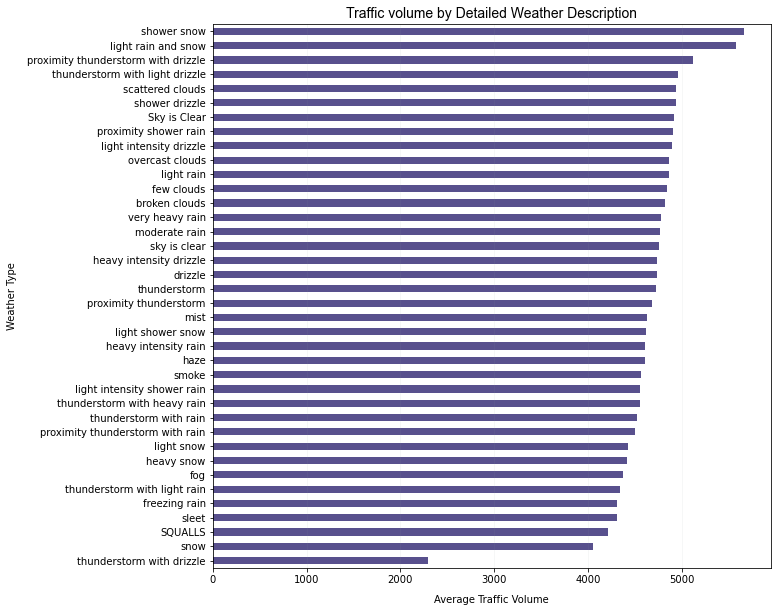

In [20]:
weather_desc = (day.groupby('weather_description')['traffic_volume']
                     .mean()
                     .reset_index(name='avg_traffic')
                     .sort_values(by='avg_traffic')
                )


weather_desc.plot.barh('weather_description', 'avg_traffic', legend=None, color='#58508d', figsize=(10,10))
plt.title('Traffic volume by Detailed Weather Description', fontsize=14, fontname='Arial')
plt.xlabel('Average Traffic Volume', labelpad=10)
plt.ylabel('Weather Type', labelpad=10)
plt.grid(axis='x', color="#93a1a1", alpha=0.1)
plt.show()

### Observations

- *There are three weather situations where traffic volume exceeds 5,000 cars:*
    - *Shower snow*.
    - *Light rain and snow*.
    - *Proximity thunderstorm with drizzles*.
- *These situations point to bad weather. It could be possible that people drove cars to work in bad weather rather than commuting through alternatives like bikes or taking walks. On careful inspection, however, we can see some other extreme days where people did not exhibit similar behaviours (for example, during thunderstorms with heavy rain). This makes it hard to conclude the underlying reasons for sure.*